# Benjamin Wilke
# Homework 4

In [1]:
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import add
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda
from tensorflow.keras.preprocessing import sequence
import numpy as np
from sklearn.metrics import confusion_matrix
from pickle import dump


## Question 1

Run one of the part-of-speech (POS) taggers available in Python. 

Find the longest sentence you can, longer than 10 words, that the POS tagger tags correctly. Show the input and output.

Find the shortest sentence you can, shorter than 10 words, that the POS tagger fails to tag 100 percent correctly. Show the input and output. Explain your conjecture as to why the tagger might have been less than perfect with this sentence.

In [ ]:
nltk.pos_tag(word_tokenize("He received the most votes in the first two states and is considered a favorite in Nevada"))

## Question 2

Run a different POS tagger in Python. Process the same two sentences from question 1.

Does it produce the same or different output?

Explain any differences as best you can.

## Question 3

In a news article from this week’s news, find a random sentence of at least 10 words.

Looking at the Penn tag set, manually POS tag the sentence yourself.

Now run the same sentences through both taggers that you implemented for questions 1 and 2. Did either of the taggers produce the same results as you had created manually?

Explain any differences between the two taggers and your manual tagging as much as you can.

## Question 4

Prepare the train.txt Dataset for insertion into a RNN.

The data is not in proper format.  Each line lists a word and 4 tags.  Your task is to form the words into sequences and form target sequences as well.

Your target is the last (fourth) tag.

Sentences are listed vertically.  A blank line indicates a new sentence.  

Form the sentences into sequences

Form the fourth tag into a sequence of targets.

Encode the data to integers.  You will need two dictionaries:

Word to integer

Target Category to integer

You should turn in the functions and code you use to perform this task—I will use them on a hidden dataset to test your success at encoding.  Padding is required—this data should be ready to put into a neural network.

In [2]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read().splitlines()
    file.close()
    return text

In [3]:
raw_doc = load_doc("train.txt")                                           #<-- load raw doc
blank_lines = [idx for idx, each in enumerate(raw_doc) if each == '']     #<-- get index of each blank line

In [4]:
# parses raw doc to return raw words and targets
def getSentencesTargets(doc, blank_lines):
    sentences = list()
    targets = list()
    
    start_index = 0                                        #<-- start at index 0
    end_index = blank_lines[0]                             #<-- set first end_index

    for current_blank in range(len(blank_lines)):
        sent_words = [word.split()[0].lower() for word in raw_doc[start_index:end_index]] #<-- isolate each word in the raw_doc range, lower()
        sentences.append(sent_words)                                                      #<-- append sentence
        target_classes = [word.split()[-1] for word in raw_doc[start_index:end_index]]    #<-- isolate each target in the raw_doc
        targets.append(target_classes)                                                    #<-- append target
        start_index = end_index + 1                        #<-- set next start_index, to last end_index + 1 (next line)
        if current_blank < len(blank_lines) - 1:           #<-- if we're not at the end of the list (protect from out of range)
            end_index = blank_lines[current_blank + 1]     #<-- then the new end_index is equal to next new end
            
    return sentences, targets            

In [5]:
# function returns true if any character in a string is a number 
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

In [6]:
# cleans raw words and targets to remove non-words while also removing corresponding non-word targets
def cleanSentencesTarget(sentences, targets):
    remove_list = ['.',',','$','(',')','\'s','\"',':','-','/','--','\'',';']      #<-- specific characters we want to remove
    
    clean_sentences = list()
    clean_targets = list()
    
    for sentence in range(len(sentences)):                      #<-- for each sentence
        current_sentence = list()
        current_target = list()                  
        for idx, word in enumerate(sentences[sentence]):        #<-- examine each word
            if word not in remove_list and not hasNumbers(word):#<-- if not in remove list or contains number
                current_sentence.append(word)                   #<-- add word to current_sentence
                current_target.append(targets[sentence][idx])   #<-- add corresponding target to current_target
        if len(current_sentence) > 0:                           #<-- only add the current sentence if it's not null
            clean_sentences.append(current_sentence)            #<-- append cleaned sentence 
            clean_targets.append(current_target)                #<-- append corresponding targets
    
    return clean_sentences, clean_targets

In [7]:
# parse raw sentence and target lists
sentences, targets = getSentencesTargets(raw_doc, blank_lines)

# clean sentence and target lists
clean_sentences, clean_targets = cleanSentencesTarget(sentences, targets)

In [8]:
def getWordCounts(sentences):
    word_counts = {}
    for sent in sentences:
        for w in sent:
            word_counts[w] = word_counts.get(w, 0) + 1
    return word_counts

In [9]:
# get dictionary of all words and corresponding occurance counts
word_counts = getWordCounts(clean_sentences)

In [10]:
# create our word to index & index to word mapping 
def createWord2IndexIndex2Word(word_counts, word_count_threshold):
    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
    idxtoword = dict(enumerate(vocab, 3))
    idxtoword[0] = '<PAD>'
    idxtoword[1] = '<UNK>'
    idxtoword[2] = '<START>'
    wordtoix = dict([(value, key) for (key, value) in idxtoword.items()])
    return wordtoix, idxtoword

In [11]:
# create our target (Y) category mapping
def createTarget2CategoryIndex(targets):
    unique_targets = list()
    for target in targets:                                                      #<-- get a list of all eligible target values
        for each in target:
            unique_targets.append(each)
    targettoix = {k:idx + 1 for idx, k in enumerate(list(set(unique_targets)))} #<-- saves room for <PAD> at 0
    targettoix["<PAD>"] = 0                                                     #<-- creates <PAD> at 0
    return targettoix

In [12]:
# create our word to index & index to word mapping - include all words since most of our Named Entities don't occur very often
wordToIndex, indexToWord = createWord2IndexIndex2Word(word_counts, 1)

# create our target (Y) category mapping
targetToIndex = createTarget2CategoryIndex(clean_targets)

In [13]:
# returns sequence of index from word sentence input, if word doesn't exist sets to 1
def sequenceFromSentenceList(sentence):
    return [wordToIndex[word] if word in wordToIndex.keys() else 1 for word in sentence]

In [14]:
# returns sequence of words from index sentence input
def sentenceFromSequenceList(sequence):
    return [indexToWord[idx] for idx in sequence]

In [15]:
# return sequence of target index from target sequence
def sequenceFromTargetSequence(targetsequence):
    return [targetToIndex[target] for target in targetsequence]

In [16]:
# let's encode our X and Y
X_data = [sequenceFromSentenceList(sent) for sent in clean_sentences]
y_data = [sequenceFromTargetSequence(target) for target in clean_targets]

The largest sequence length is: 75


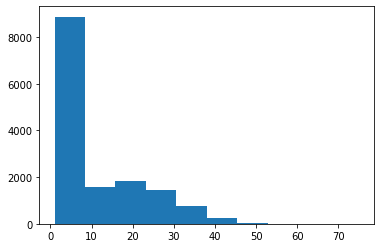

In [17]:
# lets look at sequence length
seq_length = [len(sent) for sent in clean_sentences]
print("The largest sequence length is: {}".format(max(seq_length)))
plt.hist(seq_length)
plt.show()

In [18]:
max_seq_length = 35
# now let's pad out X_data and Y_data
X = sequence.pad_sequences(X_data, maxlen=max_seq_length)
y = sequence.pad_sequences(y_data, maxlen=max_seq_length)

## Let's Model

In [19]:
embedding_vector_length = 100
vocabulary_size = len(wordToIndex)
n_tags = len(targetToIndex)

model = Sequential()
model.add(Embedding(vocabulary_size, embedding_vector_length, input_length=max_seq_length, mask_zero=True))
model.add(LSTM(units=500, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))
model.add(TimeDistributed(Dense(n_tags, activation="softmax")))
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 35, 100)           1715300   
_________________________________________________________________
lstm (LSTM)                  (None, 35, 500)           1202000   
_________________________________________________________________
time_distributed (TimeDistri (None, 35, 10)            5010      
Total params: 2,922,310
Trainable params: 2,922,310
Non-trainable params: 0
_________________________________________________________________


In [21]:
X_train, X_val = X[3000:], X[:3000]
y_train, y_val = y[3000:], y[:3000]

In [22]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=8, epochs=3, shuffle=True, verbose=1)

Train on 11724 samples, validate on 3000 samples
Epoch 1/3
11724/11724 [==============================] - 480s 41ms/sample - loss: 0.1628 - accuracy: 0.8457 - val_loss: 0.1089 - val_accuracy: 0.8925
Epoch 2/3
11724/11724 [==============================] - 501s 43ms/sample - loss: 0.0539 - accuracy: 0.9479 - val_loss: 0.0821 - val_accuracy: 0.9239
Epoch 3/3
11724/11724 [==============================] - 465s 40ms/sample - loss: 0.0304 - accuracy: 0.9693 - val_loss: 0.0790 - val_accuracy: 0.9270


In [ ]:
# save the model so you don't have to train it again in case this notebook bombs
dump(model, open('FirstTimeDistributedModel.h5', 'wb'))

In [ ]:
what = model.predict_classes(X_val)

In [ ]:
#use this cell to EXCLUDE padding from confusion matrix
count = 0
total = 0
pred = []
actual = []
for prediction in range(what.shape[0]):
    for i in range(50):
        if y_val[prediction][i]==41:
            pass
        else:
            if y_val[prediction][i]==what[prediction][i]:
                count = count+1
            total=total+1
            pred.append(what[prediction][i])
            actual.append(y_val[prediction][i])

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    all_val = list(set(actual+pred))
    tick_marks = np.arange(len(all_val))
    plt.xticks(tick_marks,[target_map[i] for i in all_val], rotation=45)
    plt.yticks(tick_marks,[target_map[i] for i in all_val])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cm = confusion_matrix(actual, pred)


np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure(figsize=(20,10))
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure(figsize=(20,10))
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
from matplotlib.pyplot import figure

plt.show()